# Spatiotemporal modeling of SDH using Python

This interactive Jupyter Notebook illustrates a Bayesian modeling workflow in Python for modeling disease incidence data using social determinants of health (SDH).
We demonstrate the power and flexiblity of this framework using the data and modeling approach proposed in Paul et. al. (2020), which compared county-level COVID-19 incidence data between urban and rural counties in April 2020.
Their methodology is based on the sophisticated spatiotemporal model proposed by Bakar and Sahu (2015) and implemented in the R package, spTimer.

### Contents
1. [Introduction](#introduction)
1. [Exploring the dataset](#exploring-the-dataset)
1. [A spatiotemporal model of SDH](#a-spatiotemporal-model-of-sdh)
1. [Low-rank Kriging for efficient spatial modeling](#low-rank-kriging-for-efficient-spatial-modeling)
1. [Modeling with PyMC](#modeling-with-pymc)

### References
1. [Bakar, K. S., & Sahu, S. K. (2015). spTimer: Spatio-temporal Bayesian modeling using R. Journal of Statistical Software, 63, 1-32.](https://www.jstatsoft.org/article/download/v063i15/834)
1. [Paul, R., Arif, A. A., Adeyemi, O., Ghosh, S., & Han, D. (2020). Progression of COVID‐19 from urban to rural areas in the United States: a spatiotemporal analysis of prevalence rates. The Journal of Rural Health, 36(4), 591-601.](https://onlinelibrary.wiley.com/doi/pdfdirect/10.1111/jrh.12486)

## Introduction

We are using several python packages.
- `pymc` is our Bayesian modeling package.
- `arviz` visualizes results from `pymc`

In [22]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import numpy as np

## Exploring the dataset

This dataset contains county-level COVID-19 prevalence data in April 2020 for 3108 counties in the contiguous United States.
- `data/prevalence.csv` contains COVID-19 prevalence data (active cases per 100,000 people) for each day in April 2020 for each county.
- `data/covariates.csv` contains county locations and variables which will be used to predict prevalence.

In [23]:
covariates = pd.read_csv("./covariates.csv")
prevalence = pd.read_csv("./prevalence.csv")

prevalence

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
0,7.194115,10.791173,10.791173,10.791173,10.791173,10.791173,12.589702,14.388230,17.985288,21.582346,...,30.574990,34.172047,37.769105,44.963220,44.963220,43.164691,43.164691,44.963220,48.560278,50.358807
1,1.834677,2.293347,2.293347,4.586693,6.880040,7.797378,8.256048,8.714717,10.549394,12.384071,...,32.106852,39.445561,40.362899,45.408262,44.032254,46.784269,49.077616,52.288301,54.581648,57.333664
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.019131,...,40.191311,44.210442,48.229573,56.267835,60.286966,72.344359,80.382621,88.420883,112.535670,116.554801
3,0.000000,0.000000,0.000000,0.000000,0.000000,8.928571,13.392857,13.392857,17.857143,17.857143,...,75.892857,75.892857,80.357143,98.214286,107.142857,116.071429,116.071429,138.392857,142.857143,147.321429
4,1.728907,3.457815,6.915629,8.644537,8.644537,8.644537,8.644537,8.644537,10.373444,15.560166,...,24.204703,25.933610,27.662517,27.662517,32.849239,34.578147,36.307054,38.035961,44.951591,48.409405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,2.322826,2.322826,2.322826,2.322826,2.322826,2.322826,4.645653,4.645653,6.968479,6.968479,...,20.905438,18.582611,23.228264,23.228264,23.228264,23.228264,23.228264,20.905438,37.165223,34.842396
3104,21.662840,30.327975,43.325679,56.323383,60.655951,69.321087,86.651358,112.646766,125.644469,138.642173,...,242.623803,233.958667,242.623803,242.623803,251.288939,264.286643,259.954075,251.288939,372.600841,389.931112
3105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.926351,4.926351,...,19.705404,19.705404,19.705404,19.705404,29.558106,29.558106,29.558106,29.558106,34.484457,29.558106
3106,0.000000,0.000000,12.682308,12.682308,12.682308,12.682308,12.682308,12.682308,12.682308,25.364616,...,63.411541,63.411541,63.411541,50.729233,63.411541,63.411541,63.411541,63.411541,101.458465,101.458465


In [24]:
covariates

,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2018,fips,lat,long,year55andolder,DMPercentage,...,highschooldiploma,somecollegeandassociate,bachelorsandhigher,povertycounts,medianhouseholdinc,associationcount,associationrate,FairPoor Health,Physically Unhealthy Days,Diabetic
0,1,1,Alabama,Autauga County,55601,1001,32.539528,-86.644081,15817,9.9,...,32.6,28.4,27.7,7587,59338,70,12.631731,18,4.2,14.0
1,1,3,Alabama,Baldwin County,218022,1003,30.727751,-87.722069,75980,8.5,...,27.6,31.3,31.3,21069,57588,223,10.692213,18,4.1,11.0
2,1,5,Alabama,Barbour County,24881,1005,31.868263,-85.387131,8043,15.7,...,35.7,25.1,12.2,6788,34382,22,8.472944,26,5.1,18.0
3,1,7,Alabama,Bibb County,22400,1007,32.996422,-87.125114,6587,13.3,...,47.3,24.4,11.5,4400,46064,23,10.157665,20,4.4,15.0
4,1,9,Alabama,Blount County,57840,1009,33.982109,-86.567909,18178,14.9,...,34.0,33.5,12.6,7527,50412,52,9.011507,21,4.5,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,56,37,Wyoming,Sweetwater County,43051,56037,41.659439,-108.882790,10969,8.7,...,33.3,35.7,22.0,3540,73315,44,9.962640,15,3.5,8.0
3104,56,39,Wyoming,Teton County,23081,56039,43.935226,-110.589080,6606,2.1,...,13.2,23.8,57.4,1443,99087,42,18.110474,12,3.2,4.0
3105,56,41,Wyoming,Uinta County,20299,56041,41.287819,-110.547580,5660,10.5,...,40.1,37.2,15.4,2010,63401,11,5.295335,16,3.7,9.0
3106,56,43,Wyoming,Washakie County,7885,56043,43.904514,-107.680180,2878,9.3,...,30.3,37.7,21.5,918,55190,16,19.429265,16,3.6,11.0


In [25]:
t_initial = 10
t_final   = 29
times = np.arange(t_initial, t_final+1)
time_names = ["V" + str(x) for x in times]
prev = prevalence[time_names]
pwr = 0.2

In [26]:
prev

,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
0,1.848501,1.848501,1.848501,1.848501,1.848501,1.816611,1.906378,1.957977,2.004647,2.004647,1.981861,2.026442,2.067413,2.140777,2.140777,2.123370,2.123370,2.140777,2.173983,2.189854
1,1.654142,1.654142,1.666217,1.761734,1.798277,1.815489,1.900110,1.934062,1.971890,1.995583,2.001334,2.085449,2.095060,2.144998,2.131838,2.157844,2.178596,2.206383,2.225406,2.247408
2,1.320768,1.517164,1.517164,1.517164,1.645321,1.645321,1.742763,2.049627,2.049627,2.093276,2.093276,2.133561,2.171014,2.238989,2.270098,2.354404,2.404542,2.450817,2.571923,2.590037
3,1.779764,1.779764,1.860992,1.990536,2.044412,2.093143,2.093143,2.178858,2.252885,2.348413,2.377060,2.377060,2.404390,2.502851,2.546787,2.587886,2.587886,2.680543,2.697618,2.714271
4,1.731422,1.768293,1.768293,1.768293,1.768293,1.768293,1.802324,1.833963,1.833963,1.863558,1.891385,1.917664,1.942577,1.942577,2.010505,2.031236,2.051154,2.070327,2.140667,2.172631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,1.474442,1.561764,1.633042,1.633042,1.633042,1.693689,1.693689,1.693689,1.746719,1.746719,1.836758,1.793995,1.875873,1.875873,1.875873,1.875873,1.875873,1.836758,2.060760,2.034331
3104,2.681508,2.745425,2.789729,2.803891,2.817772,2.844741,2.857851,2.931859,2.966226,2.999071,2.999071,2.977336,2.999071,2.999071,3.020193,3.050809,3.040740,3.020193,3.267750,3.297597
3105,1.375641,1.580196,1.580196,1.713678,1.713678,1.713678,1.713678,1.815169,1.815169,1.815169,1.815169,1.815169,1.815169,1.815169,1.968500,1.968500,1.968500,1.968500,2.030134,1.968500
3106,1.909175,1.909175,2.193066,2.193066,2.193066,2.293156,2.293156,2.293156,2.293156,2.293156,2.293156,2.293156,2.293156,2.193066,2.293156,2.293156,2.293156,2.293156,2.519171,2.519171


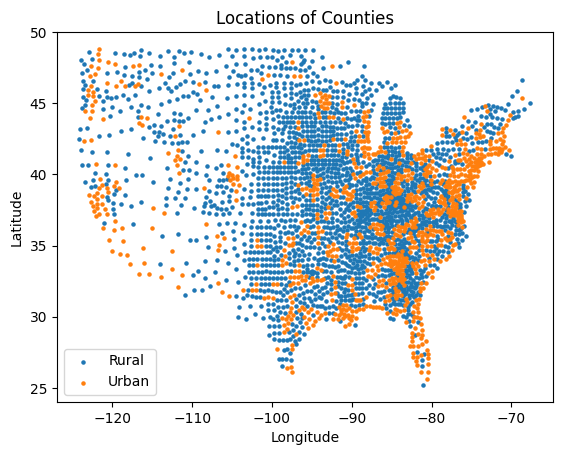

In [27]:
longitude_rural = covariates['long'].where(covariates['Rural'] == 1)
latitude_rural  = covariates['lat'].where(covariates['Rural'] == 1)
longitude_urban = covariates['long'].where(covariates['Rural'] == 0)
latitude_urban  = covariates['lat'].where(covariates['Rural'] == 0)

plt.scatter(longitude_rural, latitude_rural, s=5, label='Rural')
plt.scatter(longitude_urban, latitude_urban, s=5, label='Urban')
plt.legend()
plt.title("Locations of Counties")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

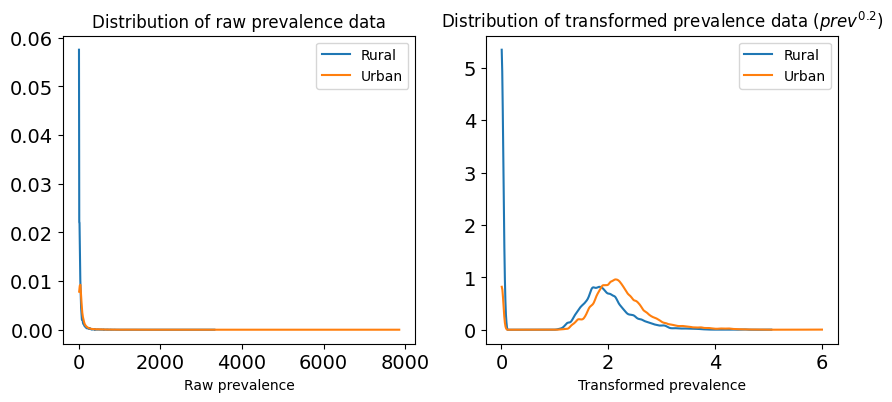

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
az.plot_kde((prev).where(covariates['Rural']==1).dropna().to_numpy(), plot_kwargs={'color':'tab:blue', 'label':'Rural'}, ax=ax[0])
az.plot_kde((prev).where(covariates['Rural']==0).dropna().to_numpy(), plot_kwargs={'color':'tab:orange', 'label':'Urban'}, ax=ax[0])
ax[0].set_xlabel('Raw prevalence')
ax[0].set_title('Distribution of raw prevalence data')
az.plot_kde((prev**pwr).where(covariates['Rural']==1).dropna().to_numpy(), plot_kwargs={'color':'tab:blue', 'label':'Rural'}, ax=ax[1])
az.plot_kde((prev**pwr).where(covariates['Rural']==0).dropna().to_numpy(), plot_kwargs={'color':'tab:orange', 'label':'Urban'}, ax=ax[1])
ax[1].set_title('Distribution of transformed prevalence data ($prev^{{ {0} }}$)'.format(pwr))
ax[1].set_xlabel('Transformed prevalence')
plt.show()

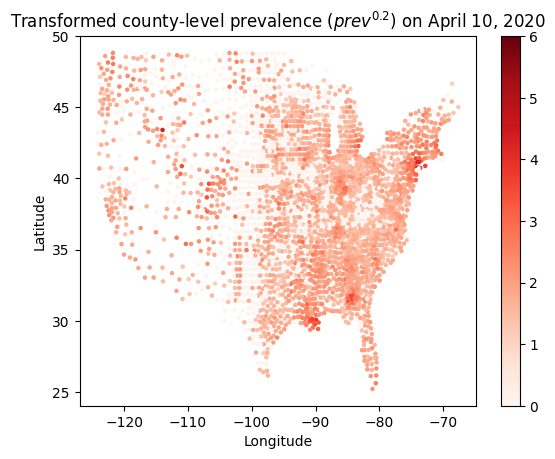

In [50]:
plt.scatter(covariates['long'], covariates['lat'], c=prev[time_names[0]]**pwr, s=5, cmap='Reds')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transformed county-level prevalence ($prev^{{ {0} }}$) on April {1}, 2020".format(pwr, t_initial))
plt.colorbar()
plt.clim([0, 6])
plt.show()

## A spatiotemporal model of SDH

The goal of this project is to show how sophisticated statistical models can be implemented in Python using the package PyMC.
Here we implement the spatiotemporal model used in the R package spTimer.
This model is special because it uses a method called low-rank Kriging to represent the spatiotemporal effects.

We have a set of data at times $t$ and spatial locations (counties) $s_\ell$:
$$D = \{(X_{\ell t}, Z_{\ell t}) : \text{for each time $t$ and location $s_\ell$}\}$$
Note that we have *fixed* spatial locations, i.e. they do not change over time.

We build a regression model as follows:
$$Z_{\ell t} = \underbrace{X_{\ell t} \beta}_{\text{regression}} + \underbrace{A_\ell w_{t}}_{\text{spatiotemporal}} + \underbrace{\epsilon_{\ell t}}_{\text{nugget}}$$
Here $X_{\ell t} \beta$ is a linear regression for the covariates.
The $A_\ell w_{t}$ term encodes the spatiotemporal correlations in the residuals.
Here we use a low-rank Kriging model where $w_{t}$ is the random effects at the "knot" locations and $A_\ell$ encodes the correlation between the knot locations and the county location $\ell$.
Finally $\epsilon_{\ell t}$ encodes the (time and space independent) noise for each observation $\epsilon_{\ell t} \sim \mathcal{N}(0, \sigma_\epsilon^2)$. 

The spatial correlations are modeled using a kernel-based Gaussian process.
Here an exponential kernel is used to calculate the covariance of the spatial random effects:
$$\kappa(s_i, s_j ; \phi) = \exp\left(-\|s_i - s_j \|\phi\right)$$
where $\phi$ is the inverse of the length scale.

However, it is very computationally expensive to calculate the spatial correlations between all the counties.
Instead, we will use an approximate method known as low-rank Kriging.
Here the spatial correlations at time $t$ are first calcualted at a set of knot points $s_k^\ast$ for each $k$.
The random effects at the knot locations are $w_t$.
At time $t=0$ the correlations are calculated using the exponential kernel
$$w_0 \sim \mathcal{N}(\mathbf{0}, \sigma_\eta^2 S_\eta)$$
where $S_\eta$ is the knot correlation matrix
$$[S_\eta]_{ij} = \kappa(s_i, s_j ; \phi).$$
For $t>0$ the random effect at knot $k$ are modeled using a vector autoregressive process
$$w_{k t} = \rho w_{k t-1} + \eta_{\ell t}$$
where
$$\eta_{\ell t} \sim \mathcal{N}(0, \sigma_\eta^2 S_\eta).$$
Note that while this is similar an $\operatorname{AR}(1)$ process, the innovations (noise) between knots are correlated.

The correlation between the knots and the spatial locations are estimated using Kriging.
Here the knots are analogous to control points.
$$A = C S_\eta^{-1}$$
where
$$[C]_{i, k} = [s_i, s_k^\ast]$$

## Low-rank Kriging for efficient spatial modeling

Here we take an aside to briefly explain low-rank Kriging, the method we are using to approximate the spatial effect of the model.

In [7]:
x_sample = np.concatenate((covariates['long'].to_numpy()[:, None], covariates['lat'].to_numpy()[:, None]), axis=1)

knots = pd.read_csv("./knots100.csv", header=None, names=["Longitude", "Latitude"])
x_knots = np.concatenate((knots["Longitude"].to_numpy()[:, None], knots["Latitude"].to_numpy()[:, None]), axis=1)

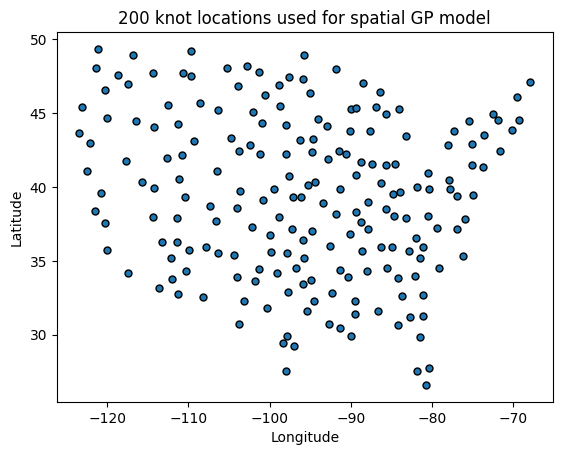

In [8]:
plt.scatter(x_knots[:, 0], x_knots[:, 1], s=25, edgecolors='k')
plt.title("200 knot locations used for spatial GP model")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [9]:
phi = 0.005
length_scale = 1/(2*phi)
cov = pm.gp.cov.Exponential(input_dim=2, ls=length_scale)
K_knots = cov(x_knots).eval()
mean_func = pm.gp.mean.Zero()
mu_knots = mean_func(x_knots).eval()

Note: `haversine_distances` expects latitude first and longitude second (the opposite of how we are storing them), and it expects latitude and longitude in radians instead of degrees.
It's distance output is in terms of radii.

In [10]:
from sklearn.metrics.pairwise import haversine_distances

x_knots_latlon_rads = np.flip(x_knots, axis=1)*2*np.pi/360
x_sample_latlon_rads = np.flip(x_sample, axis=1)*2*np.pi/360
earth_radius_km = 6371

knots_dist = haversine_distances(x_knots_latlon_rads, x_knots_latlon_rads)*earth_radius_km
rect_dist = haversine_distances(x_sample_latlon_rads, x_knots_latlon_rads)*earth_radius_km

The columns of `knots_dist` and `rect_dist` represent the distance of a particular knot from each knot or county respectively.
We can visualize these distances by plotting the first column of each matrix, which represents the distances to the first knot location.

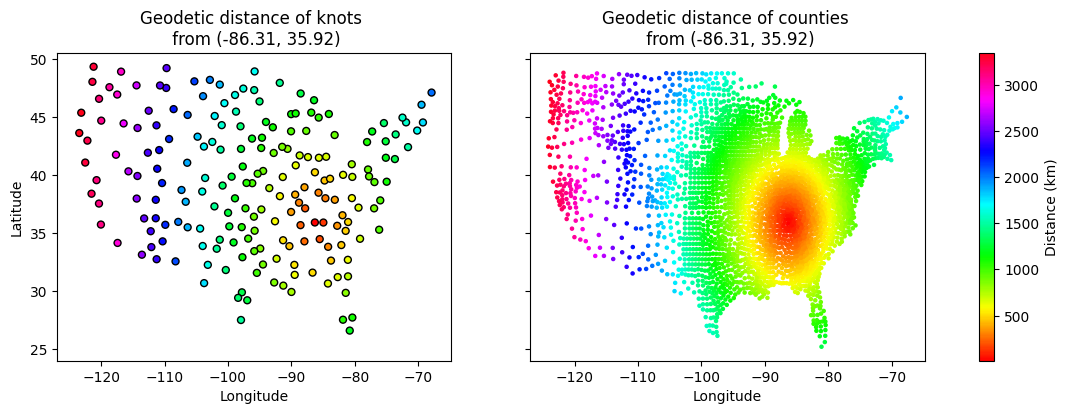

In [20]:
idx = 0
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(14,4))
ax[0].scatter(x_knots[:, 0], x_knots[:, 1], s=25, c=knots_dist[:, idx], edgecolors='k', cmap='hsv')
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].set_title(f"Geodetic distance of knots \n from ({x_knots[idx, 0]:.2f}, {x_knots[idx, 1]:.2f})")
img = ax[1].scatter(x_sample[:, 0], x_sample[:, 1], s=5, c=rect_dist[:, idx], cmap='hsv')
ax[1].set_xlabel("Longitude")
ax[1].set_title(f"Geodetic distance of counties \n from ({x_knots[idx, 0]:.2f}, {x_knots[idx, 1]:.2f})")

fig.colorbar(img, label="Distance (km)", ax=ax.ravel().tolist())
plt.show()

Note: If we wanted to use the default distance, we could have used the `full()` method, e.g. 
```
K_knot = cov.full(x_knots).eval()
K_rect = cov.full(x_sample, x_knots).eval()
```

Note: Unlike the `full()` method, the `full_from_distance()` method does not include the lengthscale, so we have to normalize the distances.

In [220]:
K_knots = cov.full_from_distance(knots_dist/length_scale).eval()
K_rect = cov.full_from_distance(rect_dist/length_scale).eval()
Kinv = np.linalg.inv(K_knots)

Here we can sample the random effects at the knot locations, then using Kriging to estimate the effects at the county locations.

In [221]:
y_knots = pm.draw(pm.MvNormal.dist(mu=mu_knots, cov=K_knots, shape=K_knots.shape[0]), draws=1).T
mu_post = K_rect@Kinv@y_knots

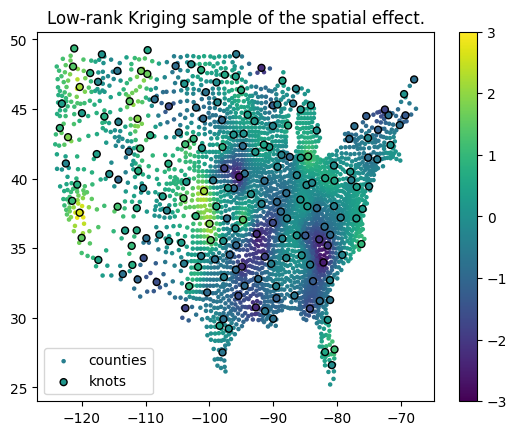

In [222]:
plt.scatter(x_sample[:, 0], x_sample[:, 1], s=5, c=mu_post, label="counties")
plt.scatter(x_knots[:, 0], x_knots[:, 1], s=25, c=y_knots, edgecolors='k', label="knots")
plt.colorbar()
plt.legend()
# plt.clim([0, 6])
plt.clim([-3, 3])
plt.title("Low-rank Kriging sample of the spatial effect.")
plt.show()

## Modeling with PyMC

We need to do some preprocessing on our data.
In particular we want all the values to be represented per capita.

In [80]:
Rural1 = covariates['Rural']
Urban1 = 1 - Rural1

Black = 100*covariates['black']/covariates['tot_pop']
BlackR = Black*Rural1
BlackU = Black*Urban1

Age25 = 100*covariates['age25_49']/covariates['tot_pop']
Age25R = Age25*Rural1
Age25U = Age25*Urban1

Smokers = covariates['Smokers']
SmokersR = Smokers*Rural1
SmokersU = Smokers*Urban1

Diabetes = covariates['Diabetic']

DiabetesR = Diabetes*Rural1
DiabetesU = Diabetes*Urban1

Obesity = covariates['pctobesity']
ObesityR = Obesity*Rural1
ObesityU = Obesity*Urban1

Association = covariates['associationrate']
AssociationR = Association*Rural1
AssociationU = Association*Urban1

PCP = covariates['PCP']
PCPR = PCP*Rural1
PCPU = PCP*Urban1

ICU = 100000*covariates['icubeds']/covariates['tot_pop']
ICUR = ICU*Rural1
ICUU = ICU*Urban1

Hospital = covariates['hospcount']
HospitalR = Hospital*Rural1
HospitalU = Hospital*Urban1

LHS = covariates['lesshighschool']
LHSR = LHS*Rural1
LHSU = LHS*Urban1

Poverty = 100*covariates['povertycounts']/covariates['tot_pop']
PovertyR = Poverty*Rural1
PovertyU = Poverty*Urban1

FairPoor = covariates[' FairPoor Health']
FairPoorR = FairPoor*Rural1
FairPoorU = FairPoor*Urban1

Rural = Rural1

Metro1 = covariates['tot_pop'] >= 500000
Metro = Metro1.astype(float)

We put everything in a pandas dataframe.

In [82]:
data = pd.DataFrame({"Rural":Rural, "Metro":Metro, "BlackR":BlackR, "BlackU":BlackU,
                     "Age25R":Age25R, "Age25U":Age25U, "SmokersR":SmokersR, "SmokersU":SmokersU, "DiabetesR":DiabetesR, "DiabetesU":DiabetesU,
                     "ObesityR":ObesityR, "ObesityU":ObesityU, "ICU":ICU, "PCP":PCP, "Hospital":Hospital})
data.tail()

,Rural,Metro,BlackR,BlackU,Age25R,Age25U,SmokersR,SmokersU,DiabetesR,DiabetesU,ObesityR,ObesityU,ICU,PCP,Hospital
3103,1,0.0,1.375113,0.0,39.778402,0.0,17.566943,0.0,8.0,0.0,30.2,0.0,23.228264,33.96355,2
3104,1,0.0,0.758199,0.0,46.913045,0.0,14.137266,0.0,4.0,0.0,13.6,0.0,25.995407,120.73649,1
3105,1,0.0,0.827627,0.0,36.031332,0.0,18.180586,0.0,9.0,0.0,31.8,0.0,29.558106,38.51153,1
3106,1,0.0,0.507292,0.0,34.039315,0.0,15.607573,0.0,11.0,0.0,29.7,0.0,0.000000,48.57316,1
3107,1,0.0,0.688962,0.0,35.137075,0.0,17.138129,0.0,9.0,0.0,30.9,0.0,0.000000,41.45937,1


In [86]:
# var_names = ["Rural"]
var_names = ["Rural", "Metro", "BlackR", "BlackU", "Age25R", "Age25U", "SmokersR", "SmokersU", "DiabetesR", "DiabetesU", "ObesityR", "ObesityU", "ICU", "PCP", "Hospital"]

# Coordinates are an optional feature of PyMC which helps to keep track of and interpret variable dimensions.
coords = {"covariates":var_names,
          "knots": knots.index,
          "locations": data.index,
          "days": time_names}

model = pm.Model(coords=coords)

X = data[var_names].to_numpy()
L = np.linalg.cholesky(K_knots)
with model:
    # These are the priors on the parameters suggested by spTimer.
    Intercept = pm.Normal("Intercept", mu=0, sigma=10)
    Slope = pm.Normal("Slope", mu=0, sigma=10**10, dims=["covariates"])
    sigma_eps = pm.Gamma("sigma_eps", alpha=2, beta=1)
    sigma_eta = pm.Gamma("sigma_eta", alpha=2, beta=1)
    rho = pm.Normal("rho", mu=0, sigma=10**10)

    # Knot effects
    noise_knots = pm.MvNormal('noise_knots', mu=mu_knots, chol=sigma_eta*L, dims=["days", "knots"])
    y_knots = [noise_knots[0, :]]
    for i_day in range(len(time_names)-1):
        y_knots.append(rho*y_knots[-1] + noise_knots[i_day+1, :])
    y_knots = pm.math.stack(y_knots, axis=-1)
    y_knots = pm.Deterministic("y_knots", y_knots, dims=["knots", "days"])

    # Spatiotemporal effect based on LRK
    mu = Intercept[None, None] + X@Slope[:, None] + K_rect@Kinv@y_knots

    # obs = pm.Normal('obs', mu=mu, sigma=sigma_eps, dims=["locations", "days"], observed=prev**pwr)

    # Censored data model.
    y_latent = pm.Normal.dist(mu=mu, sigma=sigma_eps)
    obs = pm.Censored('obs', y_latent, lower=0, upper=None, dims=["locations", "days"], observed=prev**pwr)

We can visualize the compute graph using graphviz.
Note how it gives the dimensions of each variable according to the coords we provided.

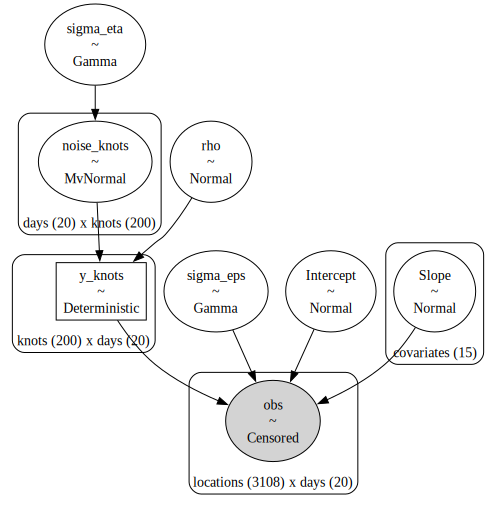

In [87]:
pm.model_to_graphviz(model)

In [88]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Slope, sigma_eps, sigma_eta, rho, noise_knots]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6034 seconds.


We do not want to output the random effects at each of the 200 knot locations, so we supress those variable names with "`~`".
Because we used coordinates for the dimensions, ArviZ labels the regression coefficients appropriately. 

In [89]:
az.summary(idata, var_names=["~y_knots", "~noise_knots"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.208,0.102,1.009,1.392,0.003,0.002,1475.0,2224.0,1.0
Slope[Rural],-1.821,0.108,-2.036,-1.628,0.002,0.002,1962.0,2165.0,1.0
Slope[Metro],0.004,0.022,-0.035,0.048,0.000,0.000,4106.0,3039.0,1.0
Slope[BlackR],0.008,0.000,0.007,0.009,0.000,0.000,3512.0,3020.0,1.0
Slope[BlackU],0.004,0.001,0.003,0.005,0.000,0.000,2847.0,2825.0,1.0
Slope[Age25R],0.041,0.001,0.039,0.044,0.000,0.000,3504.0,3246.0,1.0
Slope[Age25U],-0.001,0.002,-0.005,0.003,0.000,0.000,2101.0,2509.0,1.0
Slope[SmokersR],0.009,0.002,0.006,0.012,0.000,0.000,3858.0,3415.0,1.0
Slope[SmokersU],0.011,0.002,0.007,0.015,0.000,0.000,4108.0,3137.0,1.0
Slope[DiabetesR],-0.022,0.003,-0.027,-0.017,0.000,0.000,3521.0,3247.0,1.0


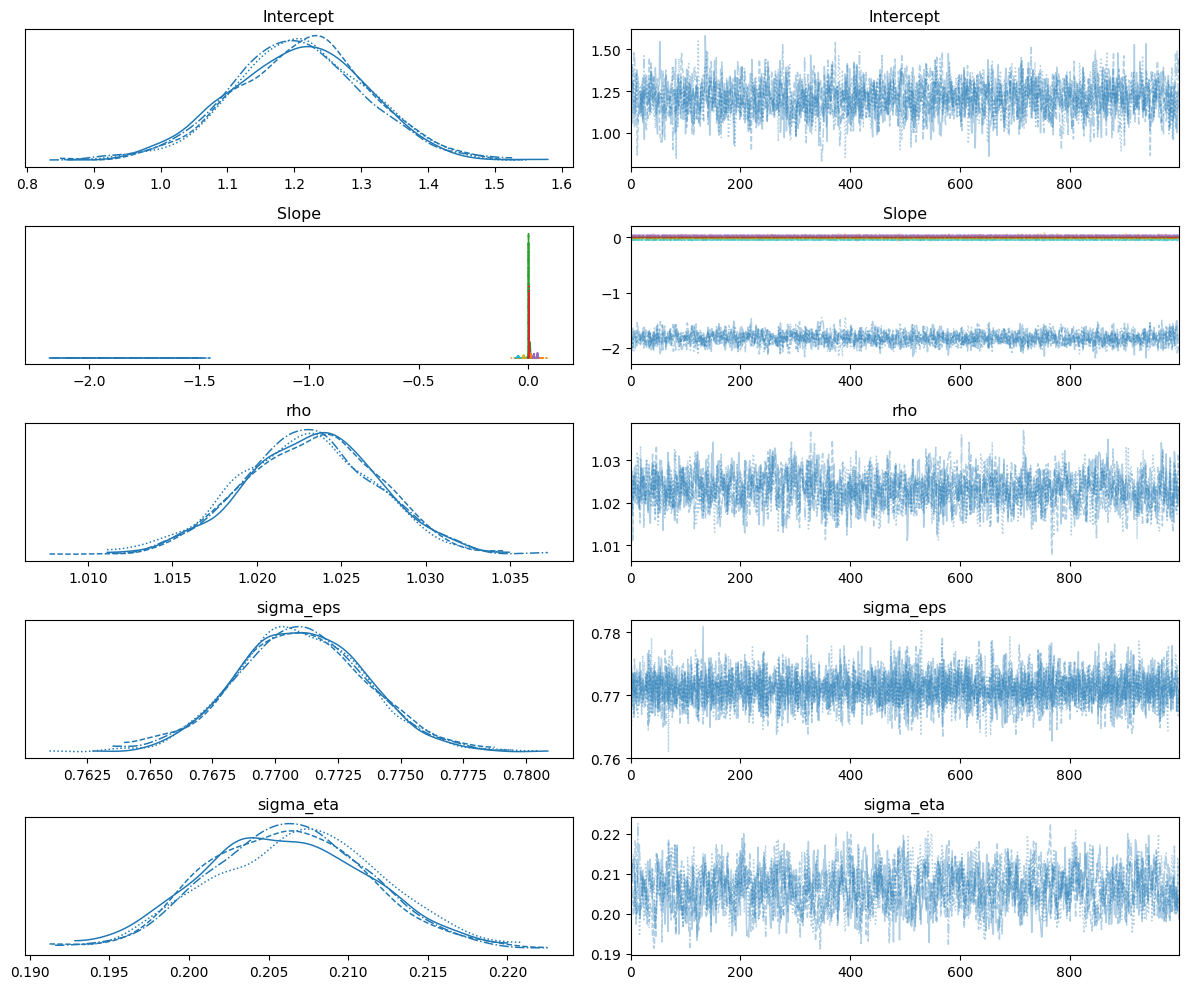

In [90]:
az.plot_trace(idata, var_names=["~y_knots", "~noise_knots"])
plt.tight_layout()
plt.show()